In [90]:
import pandas as pd

In [124]:
db_init = pd.read_csv("C:/Users/valentin.stuhlfauth/OneDrive - univ-lyon2.fr/2_2025 [DUT] systematic review/2_Topic modelling/0_code/2025_Pol4PED_systematic_review/0_data/2025-02-27_Screening_result.csv",sep=';',encoding='ISO-8859-1')

db_init=db_init.reset_index()
data=db_init[db_init["Approach"].isin(['Conceptual', 'Quantitative', 'Qualitative'])]

df_text = pd.DataFrame()
df_text["text_topic"] = data["Article Title"] + " " + data["Abstract"]

### Lemmatization

In [125]:
import pandas as pd
import spacy
from collections import Counter
import re  # Import regex module

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [126]:
# Function to preprocess and lemmatize keywords
def lemmatize_keywords(keyword_str):
    if pd.isna(keyword_str):
        return None
    # Remove spaces around semicolons, replace hyphens inside words with a space
    keywords = [re.sub(r'(?<=\w)-(?=\w)', ' ', kw.strip().lower()) for kw in keyword_str.split(";")]
    lemmatized = [" ".join([token.lemma_ for token in nlp(kw)]) for kw in keywords]
    return "; ".join(lemmatized)

In [127]:
# Create a new column with lemmatized keywords
db_init["Lemmatized Keywords"] = db_init["Author Keywords"].apply(lemmatize_keywords)

# Flatten the lemmatized keywords into a list
all_keywords = [kw for sublist in db_init["Lemmatized Keywords"].dropna().str.split("; ") for kw in sublist]


### Process

In [128]:
# Count occurrences
keyword_counts = Counter(all_keywords)

# Convert to DataFrame
df_counts = pd.DataFrame(keyword_counts.items(), columns=["Keyword", "Count"])

# Filter by occurrence 
df_counts = df_counts[df_counts["Count"] > 5].sort_values(by="Count", ascending=False)

# Reset index
df_counts.reset_index(drop=True, inplace=True)

In [129]:
# Export df_counts to an Excel file
df_counts.to_excel("C:/Users/valentin.stuhlfauth/OneDrive - univ-lyon2.fr/2_2025 [DUT] systematic review/2_Topic modelling/0_code/2025_Pol4PED_systematic_review/0_data/2025-03-27_Keyword-extract.xlsx", index=False, engine="openpyxl")

### Grouping the keywords

In [130]:
# Dictionary mapping keywords to clusters
keyword_cluster_mapping = {
    "low carbon city": "Low Carbon City",
    "positive energy district": "Positive Energy District",
    "low carbon city pilot policy": "Low Carbon City",
    "low carbon economy": "Low Carbon Economy and Society",
    "smart city": "Smart City",
    "low carbon development": "Low Carbon Development, Transition, Transformation and Policy",
    "low carbon city pilot": "Low Carbon City",
    "low carbon transition": "Low Carbon Development, Transition, Transformation and Policy",
    "sustainable city": "Sustainable City",
    "low carbon city ( lcc )": "Low Carbon City",
    "low carbon transportation": "Low Carbon Transportation and Travel",
    "positive energy district ( ped )": "Positive Energy District",
    "low carbon pilot city": "Low Carbon City",
    "green building": "Green Building",
    "low carbon transformation": "Low Carbon Development, Transition, Transformation and Policy",
    "low carbon eco city": "Low Carbon City",
    "zero energy district": "Zero or Net Zero Energy District",
    "low carbon transport": "Low Carbon Transportation and Travel",
    "low carbon travel": "Low Carbon Transportation and Travel",
    "compact city": "Compact City",
    "low -carbon city pilot policy": "Low Carbon City",
    "low carbon building": "Low Carbon Building",
    "net zero energy building": "Zero Energy Building",
    "net zero energy district": "Zero or Net Zero Energy District",
    "low carbon policy": "Low Carbon Development, Transition, Transformation and Policy",
    "zero emission neighbourhood": "Zero Emission Neighbourhood",
    "low carbon city construction": "Low Carbon City",
    "climate neutral city": "Low Carbon City",
    "low carbon pilot policy": "Low Carbon City",
    "low carbon city policy": "Low Carbon City",
    "low carbon society": "Low Carbon Economy and Society",
    "low carbon innovation": "Low Carbon Development, Transition, Transformation and Policy",
    "nearly zero energy district": "Zero or Net Zero Energy District",
    "low carbon tourism": "Low Carbon Tourism",
    "low carbon pilot": "Low Carbon City",
    "low carbon green city": "Low Carbon City",
    "zero energy building": "Zero Energy Building",
    "low -carbon city": "Low Carbon City",
    "positive energy block": "Positive Energy District"
}

# Function to assign clusters only for listed keywords
def map_clusters(keyword_str):
    if pd.isna(keyword_str):
        return None
    keywords = keyword_str.split("; ")  # Split multiple keywords
    clusters = [keyword_cluster_mapping[kw] for kw in keywords if kw in keyword_cluster_mapping]  # Only mapped ones
    return "; ".join(set(clusters)) if clusters else None  # Join unique clusters or return None

# Apply mapping to db_init
db_init["Keyword Cluster"] = db_init["Lemmatized Keywords"].apply(map_clusters)

### Visuals

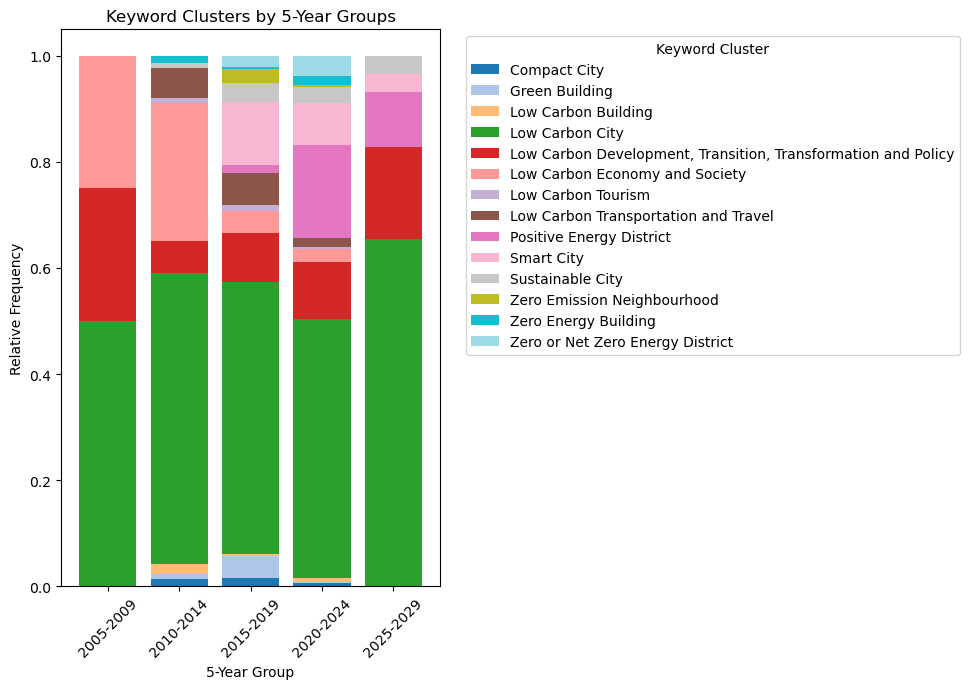

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

df=db_init
# Step 1: Expand the "Keyword Cluster" column into a list of individual keywords, handle None/NaN values
df['Keyword Cluster'] = df['Keyword Cluster'].apply(lambda x: x.split('; ') if isinstance(x, str) else [])

# Step 2: Flatten the DataFrame so that each row is a publication and each keyword is separate
expanded_df = df.explode('Keyword Cluster')

# Step 3: Create a column for the 5-year groupings
def get_5_year_group(year):
    return f"{(year // 5) * 5}-{(year // 5) * 5 + 4}"

expanded_df['5-Year Group'] = expanded_df['Publication Year'].apply(get_5_year_group)

# Step 4: Count the frequency of each keyword in each 5-year group
keyword_counts = expanded_df.groupby(['5-Year Group', 'Keyword Cluster']).size().unstack(fill_value=0)

# Step 5: Normalize the counts to create the 100% stacked bar data
keyword_counts_normalized = keyword_counts.div(keyword_counts.sum(axis=1), axis=0)

# Step 6: Plot the 100% stacked bar chart
ax = keyword_counts_normalized.plot(kind='bar', stacked=True, figsize=(10, 7), cmap='tab20', width=0.8)

# Step 7: Customize the plot
plt.title('Keyword Clusters by 5-Year Groups')
plt.xlabel('5-Year Group')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=45)
plt.legend(title='Keyword Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


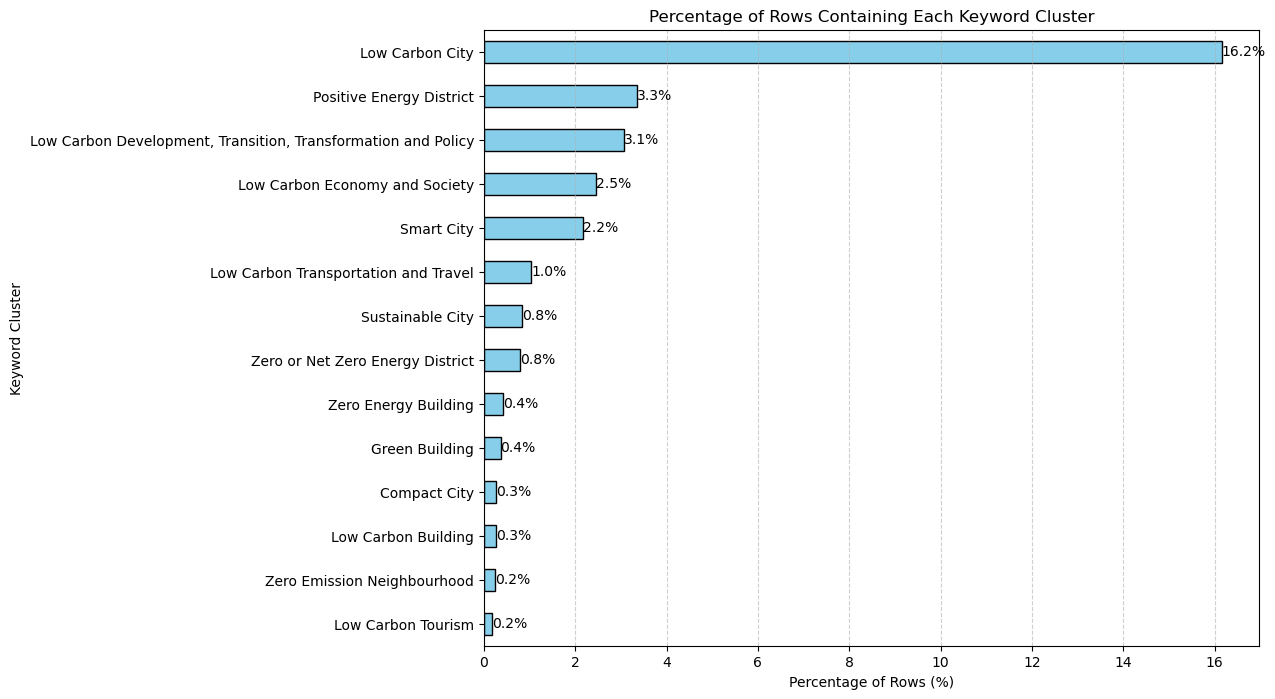

In [ ]:
import matplotlib.pyplot as plt

# Count occurrences of each keyword cluster
cluster_counts = db_init["Keyword Cluster"].dropna().str.split("; ").explode().value_counts()

# Compute percentage of rows containing each cluster
cluster_percentages = (cluster_counts / len(db_init)) * 100  # Convert to percentage

# Plot (horizontal bar chart)
plt.figure(figsize=(10, 8))
ax = cluster_percentages.sort_values(ascending=True).plot(kind="barh", color="skyblue", edgecolor="black")

# Labels and formatting
plt.xlabel("Percentage of Papers (%)")
plt.ylabel("Keyword Cluster")
plt.title("Percentage of Rows Containing Each Keyword Cluster")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Annotate bars with percentage values
for p in ax.patches:
    ax.annotate(f"{p.get_width():.1f}%", 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha="left", va="center", fontsize=10)

plt.show()

In [ ]:
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text using spaCy
def lemmatize_text_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Lemmatize and remove stopwords/punctuation
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(lemmatized_tokens)

# Step 1: Merge 'Article Title' and 'Abstract' into a new column 'Text'
db_init['Text'] = db_init['Article Title'].fillna('') + ' ' + db_init['Abstract'].fillna('')

# Step 2: Lemmatize the merged text using spaCy
db_init['Lemmatized Text'] = db_init['Text'].apply(lemmatize_text_spacy)

# Step 3: Generate word clouds for each individual 'Keyword Cluster'
# Split the 'Keyword Cluster' list by '; ' and process each keyword cluster
clusters_list = db_init['Keyword Cluster'].dropna().str.split('; ')

# Flatten the list of clusters to process each one separately
flattened_clusters = [cluster for sublist in clusters_list for cluster in sublist]

# Create a set of unique clusters
unique_clusters = set(flattened_clusters)

# Plot word clouds for each cluster
for cluster in unique_clusters:
    # Get all the lemmatized texts for rows that contain this cluster
    cluster_text = db_init[db_init['Keyword Cluster'].str.contains(cluster, na=False)]['Lemmatized Text'].str.cat(sep=' ')
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=15, background_color='white').generate(cluster_text)
    
    # Plotting the wordcloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{cluster}", fontsize=14)
    plt.show()

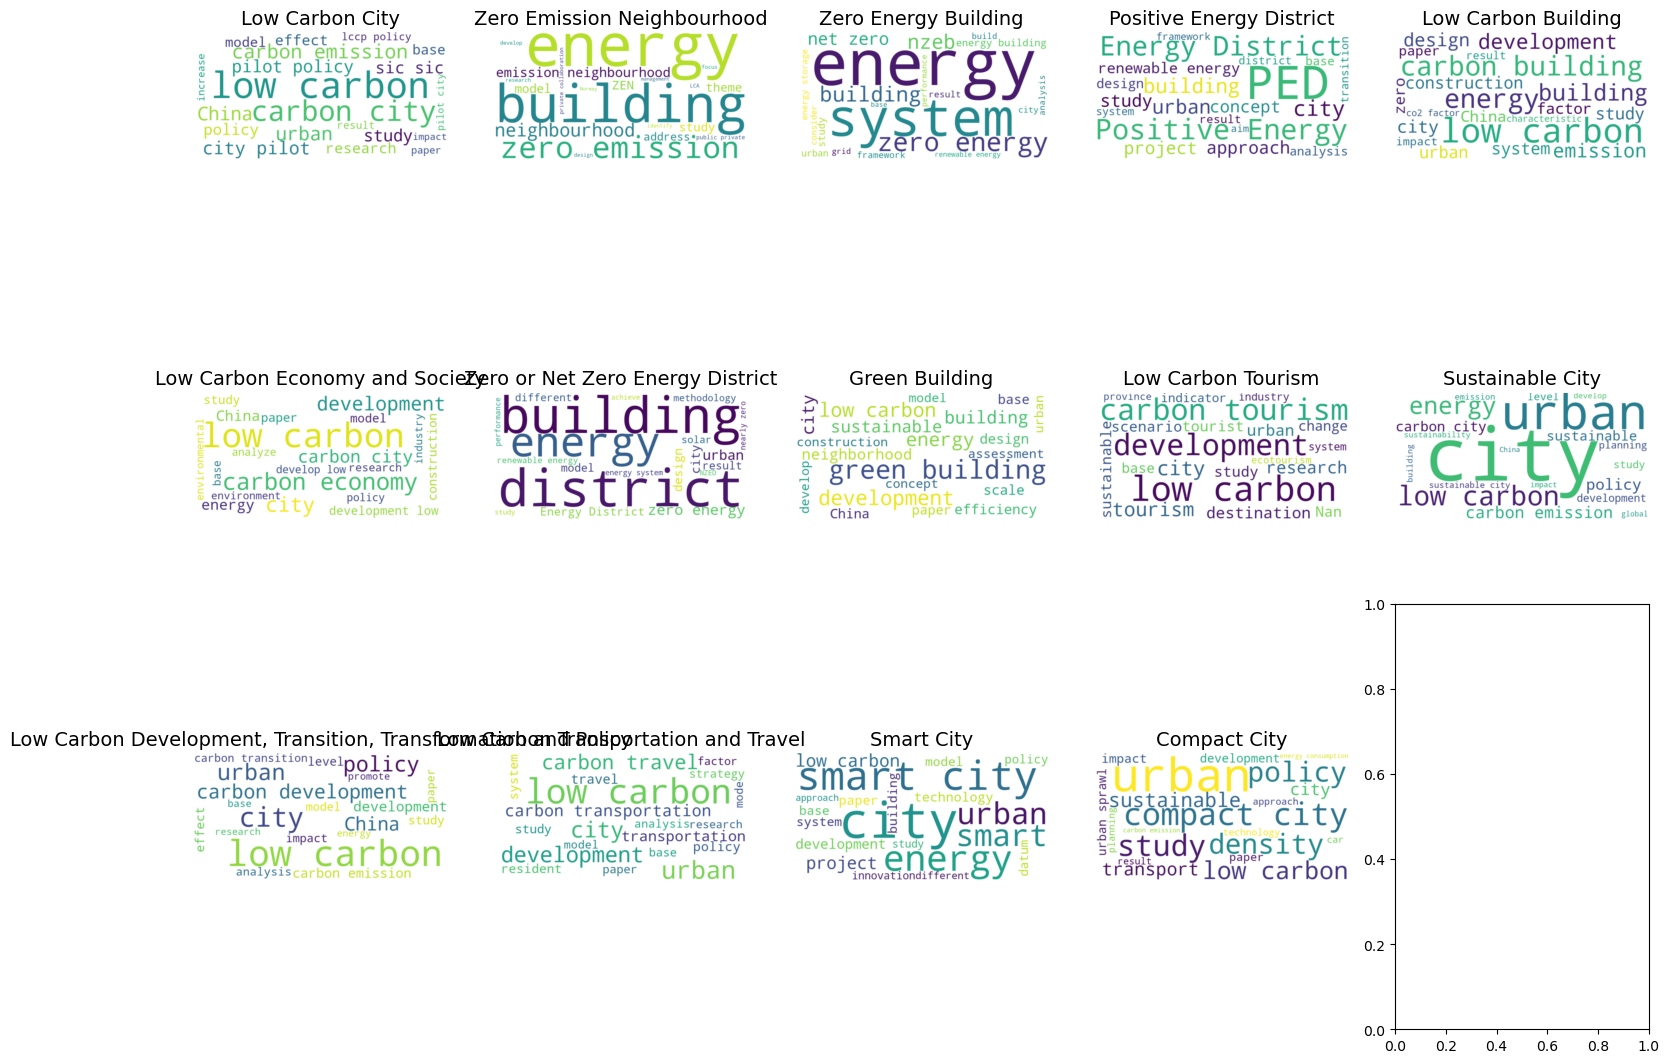

In [71]:
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text using spaCy
def lemmatize_text_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Lemmatize and remove stopwords/punctuation
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(lemmatized_tokens)

# Step 1: Merge 'Article Title' and 'Abstract' into a new column 'Text'
db_init['Text'] = db_init['Article Title'].fillna('') + ' ' + db_init['Abstract'].fillna('')

# Step 2: Lemmatize the merged text using spaCy
db_init['Lemmatized Text'] = db_init['Text'].apply(lemmatize_text_spacy)

# Step 3: Generate word clouds for each individual 'Keyword Cluster'
# Split the 'Keyword Cluster' list by "; " and process each keyword cluster
clusters_list = db_init['Keyword Cluster'].dropna().str.split('; ')

# Flatten the list of clusters to process each one separately
flattened_clusters = [cluster for sublist in clusters_list for cluster in sublist]

# Create a set of unique clusters
unique_clusters = set(flattened_clusters)

# Step 4: Plot word clouds in a 3x5 grid
# Create a figure for subplots (3 rows, 5 columns)
fig, axes = plt.subplots(3, 5, figsize=(15, 12))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Plot the word clouds
for i, cluster in enumerate(unique_clusters):
    if i >= len(axes):  # Avoid exceeding the number of axes
        break

    # Get all the lemmatized texts for rows that contain this cluster
    cluster_text = db_init[db_init['Keyword Cluster'].str.contains(cluster, na=False)]['Lemmatized Text'].str.cat(sep=' ')
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(cluster_text)
    
    # Plotting the wordcloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(cluster, fontsize=14)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
